## Organizing the data

In [1]:
# Find Current directory
import os

# Get the current working directory
current_directory = os.getcwd()

# Print the current working directory
print("Current Working Directory:", current_directory)

Current Working Directory: /workspace/jetbot/notebooks/testing/training 


In [3]:
import csv

# Path to your CSV file
csv_file_path = '/workspace/jetbot/notebooks/testing/data collection/collected_data/labels.csv'

# Open and read the CSV file
with open(csv_file_path, mode='r') as file:
    reader = csv.reader(file)
    header = next(reader)  # Skip the header row
    data = []
    for row in reader:
        data.append(row)

# Display the first few rows to verify the format
for row in data[:5]:
    print(row)



['collected_data/20240804_173148205561.jpg', 'up']
['collected_data/20240804_173153425657.jpg', 'up']
['collected_data/20240804_173156842607.jpg', 'up']
['collected_data/20240804_173157042747.jpg', 'up']
['collected_data/20240804_173208493632.jpg', 'up']


## Add header

In [5]:
import csv

# Path to your CSV file
csv_file_path = '/workspace/jetbot/notebooks/testing/data collection/collected_data/labels.csv'

# Read the existing data
with open(csv_file_path, mode='r') as file:
    reader = csv.reader(file)
    data = [row for row in reader]

# Add the header
header = ['image', 'label']

# Write the data back with the header
with open(csv_file_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(header)  # Write the header
    writer.writerows(data)   # Write the data

print("Header added and data written successfully.")


Header added and data written successfully.


## Remove Duplicate Header

In [6]:
import csv

# Path to your CSV file
csv_file_path = '/workspace/jetbot/notebooks/testing/data collection/collected_data/labels.csv'

# Read the existing data and remove duplicate headers
cleaned_data = []
header = ['image', 'label']

with open(csv_file_path, mode='r') as file:
    reader = csv.reader(file)
    for row in reader:
        if row != header:  # Skip the duplicate header
            cleaned_data.append(row)

# Write the cleaned data back with the correct header
with open(csv_file_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(header)  # Write the header
    writer.writerows(cleaned_data)  # Write the cleaned data

print("Duplicate header removed and data cleaned successfully.")


Duplicate header removed and data cleaned successfully.


## Preprocess the data

In [2]:
import csv

# Path to your CSV file
csv_file_path = '/workspace/jetbot/notebooks/testing/data collection/collected_data/labels.csv'

# Read the existing data and print the first few entries
with open(csv_file_path, mode='r') as file:
    reader = csv.reader(file)
    next(reader)  # Skip the header
    data = [row for row in reader]

# Print the first few entries to verify paths
for row in data[:5]:
    print(row)


['collected_data/20240804_173148006442.jpg', 'up']
['collected_data/20240804_173148205561.jpg', 'up']
['collected_data/20240804_173153425657.jpg', 'up']
['collected_data/20240804_173156842607.jpg', 'up']
['collected_data/20240804_173157042747.jpg', 'up']


In [3]:
import os

# Path to your image directory
image_dir = '/workspace/jetbot/notebooks/testing/data collection/collected_data'

# List files in the directory
files = os.listdir(image_dir)
print(files[:10])  # Print the first 10 files to verify


['20240804_173220945949.jpg', '20240804_173244051480.jpg', '20240804_191642178160.jpg', '20240804_191726210976.jpg', '20240804_191255760612.jpg', '20240804_173148006442.jpg', '20240804_180115733122.jpg', '20240804_173241833339.jpg', '20240804_185324196486.jpg', '20240804_191638402266.jpg']


## Define the model

## Training Loop

In [10]:
import os
import csv
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import time

# Dataset class with data augmentation
class RoadFollowingDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data = []
        with open(csv_file, mode='r') as file:
            reader = csv.reader(file)
            next(reader)  # Skip the header
            for row in reader:
                self.data.append([os.path.basename(row[0]), row[1]])
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.data[idx][0])
        if not os.path.exists(img_name):
            raise FileNotFoundError(f"File not found: {img_name}")

        image = Image.open(img_name).convert('RGB')
        label = self.data[idx][1]

        if self.transform:
            image = self.transform(image)

        label_dict = {'up': 0, 'down': 1, 'left': 2, 'right': 3, 'obstacle': 4}
        label = label_dict[label]

        return image, label

# Data augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Initialize the dataset and dataloader
csv_file_path = '/workspace/jetbot/notebooks/testing/data collection/collected_data/labels.csv'
root_dir = '/workspace/jetbot/notebooks/testing/data collection/collected_data'
dataset = RoadFollowingDataset(csv_file=csv_file_path, root_dir=root_dir, transform=transform)
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Model definition
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=5):
        super(SimpleCNN, self).__init__()
        self.features = models.resnet18(pretrained=True)
        self.features.fc = nn.Linear(self.features.fc.in_features, num_classes)

    def forward(self, x):
        x = self.features(x)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleCNN(num_classes=5)
model = model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Early stopping
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.01):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = None
        self.counter = 0

    def should_stop(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
            return False
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
            return False

early_stopping = EarlyStopping(patience=5, min_delta=0.01)

# Training loop
num_epochs = 50
train_losses = []
val_losses = []
start_time = time.time()

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(data_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 10 == 9:
            print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 10:.3f}")
            running_loss = 0.0

    scheduler.step()

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data in data_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_loss /= len(data_loader)
    val_losses.append(val_loss)
    print(f"Epoch {epoch + 1} validation loss: {val_loss:.3f}")

    if early_stopping.should_stop(val_loss):
        print(f"Early stopping at epoch {epoch + 1}")
        break

print('Finished Training')

# Save the trained model
save_path = '/workspace/jetbot/notebooks/testing/training/road_following_model.pth'
os.makedirs(os.path.dirname(save_path), exist_ok=True)
torch.save(model.state_dict(), save_path)
print(f'Model saved to {save_path}')


[1, 10] loss: 0.607
[1, 20] loss: 0.067
[1, 30] loss: 0.024
Epoch 1 validation loss: 0.047
[2, 10] loss: 0.013
[2, 20] loss: 0.046
[2, 30] loss: 0.065
Epoch 2 validation loss: 0.115
[3, 10] loss: 0.076
[3, 20] loss: 0.059
[3, 30] loss: 0.034
Epoch 3 validation loss: 0.029
[4, 10] loss: 0.046
[4, 20] loss: 0.018
[4, 30] loss: 0.010
Epoch 4 validation loss: 0.023
[5, 10] loss: 0.035
[5, 20] loss: 0.019
[5, 30] loss: 0.013
Epoch 5 validation loss: 0.265
[6, 10] loss: 0.009
[6, 20] loss: 0.040
[6, 30] loss: 0.002
Epoch 6 validation loss: 0.003
[7, 10] loss: 0.009
[7, 20] loss: 0.002
[7, 30] loss: 0.002
Epoch 7 validation loss: 0.001
[8, 10] loss: 0.002
[8, 20] loss: 0.002
[8, 30] loss: 0.001
Epoch 8 validation loss: 0.001
[9, 10] loss: 0.001
[9, 20] loss: 0.001
[9, 30] loss: 0.001
Epoch 9 validation loss: 0.001
[10, 10] loss: 0.024
[10, 20] loss: 0.015
[10, 30] loss: 0.004
Epoch 10 validation loss: 0.000
[11, 10] loss: 0.000
[11, 20] loss: 0.003
[11, 30] loss: 0.002
Epoch 11 validation los

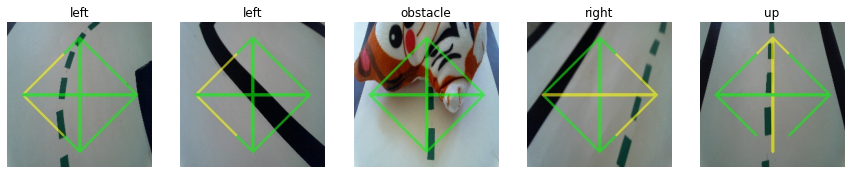

In [8]:
import matplotlib.pyplot as plt
import random

# Function to display images and labels
def display_random_images(dataset, root_dir, num_images=5):
    plt.figure(figsize=(15, 5))
    
    for i in range(num_images):
        idx = random.randint(0, len(dataset) - 1)
        img_name = dataset[idx][0]
        label = dataset[idx][1]
        img_path = os.path.join(root_dir, img_name)

        image = Image.open(img_path).convert('RGB')

        plt.subplot(1, num_images, i + 1)
        plt.imshow(image)
        plt.title(label)
        plt.axis('off')
    
    plt.show()

# Display random images with labels
display_random_images(dataset.data, root_dir)
